# Mini Project: Customer Churn with SparkML
**Authors:** Arun Kumar Aluru (rosariAdr)

## Phase 1: Setup and Data Loading
Initialize SparkSession and load data.

In [13]:
! pip install pyspark

In [14]:

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

# Create a SparkSession
spark = SparkSession.builder \
   .appName("ChurnPredictionPipeline") \
   .getOrCreate()

# Load the Dataset
df = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

# Initial Data Inspection
df.printSchema()
df.show(5)
print(f"Total Rows: {df.count()}")

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

## Phase 2: Exploratory Data Analysis (EDA) & Data Cleaning
Handling missing values and exploring single & paired variables.

In [15]:
# 2.1 Data preparation
# TotalCharges might contain spaces for new customers. Let's replace spaces with null and then cast to Double.
df = df.withColumn("TotalCharges", F.when(F.trim(F.col("TotalCharges")) == "", None).otherwise(F.col("TotalCharges")).cast(DoubleType()))

# 2.2 Data Cleaning (Handling Missing Values)
print("Count of null values in each column:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Drop rows with null values
df_clean = df.na.drop()
print(f"Total Rows after dropping nulls: {df_clean.count()}")

# 2.3 Univariate Analysis
# Numerical Features
numerical_cols = [t[0] for t in df_clean.dtypes if t[1] == 'int' or t[1] == 'double']
print("Numerical Columns Summary:")
df_clean.select(numerical_cols).summary().show()

# Categorical Features
categorical_cols = [t[0] for t in df_clean.dtypes if t[1] == 'string']
categorical_cols.remove("customerID") # Exclude identifier
print("Categorical Columns Counts:")
for col in categorical_cols[:3]: # Showing first 3 for brevity
    df_clean.groupBy(col).count().orderBy(F.desc("count")).show()

# 2.4 Bivariate Analysis
# How contract type relates to Churn
print("Churn by Contract Type:")
df_clean.groupBy("Contract", "Churn").count().orderBy("Contract").show()


Count of null values in each column:
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|      

## Phase 3 & 4: Data Transformation
Convert strings to indices, assemble vectors, scale, and define Logistic Regression.

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

# 3.1 Identify Feature Columns
categorical_cols.remove("Churn") # target column

# Convert target to numerical
df_clean = df_clean.withColumn("Churn_Index", F.when(F.col("Churn") == "Yes", 1.0).otherwise(0.0))

# 3.2 Define Pipeline Stages
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]
assembler_inputs = [c+"_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)


##  Building the  ML Pipeline

In [17]:

# 4.1 Define Model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Churn_Index", maxIter=10, regParam=0.01)

# 4.2 Assemble Pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, lr])

print("Pipeline created successfully with the following stages:")
for i, stage in enumerate(pipeline.getStages()):
    print(f"  {i+1}. {stage}")


Pipeline created successfully with the following stages:
  1. StringIndexer_890a7eafafeb
  2. StringIndexer_16d0636962a8
  3. StringIndexer_38021a9424c9
  4. StringIndexer_a1374e3bfc5d
  5. StringIndexer_f92f04f46671
  6. StringIndexer_6e731840578c
  7. StringIndexer_9766310674fc
  8. StringIndexer_af28e3313fb3
  9. StringIndexer_346d5518a44c
  10. StringIndexer_2a305e34c2e9
  11. StringIndexer_cb144da8e12e
  12. StringIndexer_d2acaa614060
  13. StringIndexer_5469790b37fe
  14. StringIndexer_fb34b172a287
  15. StringIndexer_8a2c15accb54
  16. VectorAssembler_a8b89146a767
  17. StandardScaler_d93af7c0a26d
  18. LogisticRegression_2ccb6fa467f9


## Phase 5: Model Training and Evaluation
Split data, fit pipeline, predict and assess Accuracy/F1.

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 5.1 Split Data
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

# 5.2 Train Model
model = pipeline.fit(train_data)

# 5.3 Make Predictions
predictions = model.transform(test_data)

print("Sample predictions:")
predictions.select("customerID", "Churn_Index", "prediction", "probability").show(5)

# Evaluate model
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Churn_Index", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Churn_Index", predictionCol="prediction", metricName="f1")

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print("-" * 40)
print(f"Test Accuracy = {accuracy:.4f}")
print(f"Test F1 Score = {f1_score:.4f}")
print("-" * 40)


Sample predictions:
+----------+-----------+----------+--------------------+
|customerID|Churn_Index|prediction|         probability|
+----------+-----------+----------+--------------------+
|0004-TLHLJ|        1.0|       1.0|[0.35890813197706...|
|0013-SMEOE|        0.0|       0.0|[0.91424244071453...|
|0015-UOCOJ|        0.0|       0.0|[0.55462617106781...|
|0019-EFAEP|        0.0|       0.0|[0.91041840647375...|
|0023-HGHWL|        1.0|       1.0|[0.37455596820547...|
+----------+-----------+----------+--------------------+
only showing top 5 rows
----------------------------------------
Test Accuracy = 0.8137
Test F1 Score = 0.8050
----------------------------------------


## Phase 6: Data Visualization with Seaborn
Convert a sample/aggregation to pandas for plotting.

/var/folders/_r/dsqqyf3j35n3c4qyf0ypk4n00000gn/T/ipykernel_8602/1173898398.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=pd_df, palette='viridis')
/var/folders/_r/dsqqyf3j35n3c4qyf0ypk4n00000gn/T/ipykernel_8602/1173898398.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='tenure', data=pd_df, palette='viridis')


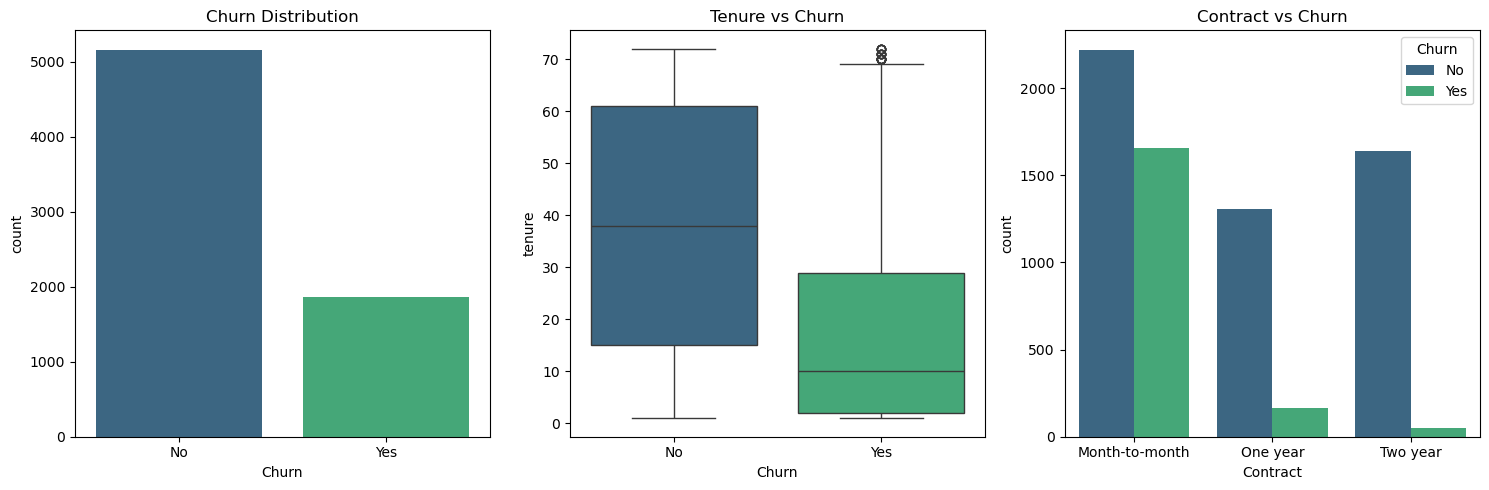

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert clean spark dataframe to pandas dataframe for seaborn
# We can do this directly since Telco data is small (~7000 rows)
pd_df = df_clean.toPandas()

plt.figure(figsize=(15, 5))

# Plot 1: Churn Distribution (Bar Plot)
plt.subplot(1, 3, 1)
sns.countplot(x='Churn', data=pd_df, palette='viridis')
plt.title('Churn Distribution')

# Plot 2: Tenure vs Churn (Box Plot)
plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='tenure', data=pd_df, palette='viridis')
plt.title('Tenure vs Churn')

# Plot 3: Contract Type vs Churn (Count Plot)
plt.subplot(1, 3, 3)
sns.countplot(x='Contract', hue='Churn', data=pd_df, palette='viridis')
plt.title('Contract vs Churn')

plt.tight_layout()
plt.show()


## Phase 8: Traditional Way (Pandas & Scikit-learn)
Replicating the pipeline using standard python libraries.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Data Loading & Cleaning
df_pd = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_pd['TotalCharges'] = pd.to_numeric(df_pd['TotalCharges'], errors='coerce')
df_pd = df_pd.dropna()

# Separation and encoding
X_pd = df_pd.drop(['customerID', 'Churn'], axis=1)
y_pd = df_pd['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables
for col in X_pd.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_pd[col] = le.fit_transform(X_pd[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)

# Scaling
scaler_pd = StandardScaler()
X_train_scaled = scaler_pd.fit_transform(X_train)
X_test_scaled = scaler_pd.transform(X_test)

# Model Training
lr_pd = LogisticRegression(max_iter=1000)
lr_pd.fit(X_train_scaled, y_train)

# Evaluation
y_pred = lr_pd.predict(X_test_scaled)
print("Scikit-Learn Model Results:")
print("-" * 40)
print(f"Test Accuracy = {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 Score = {f1_score(y_test, y_pred):.4f}")
print("-" * 40)


Scikit-Learn Model Results:
----------------------------------------
Test Accuracy = 0.7854
Test F1 Score = 0.5506
----------------------------------------


## Phase 9: Optimisations
Applying an optimization: Using CrossValidator with parameter grid on PySpark Pipeline, and switching to RandomForest.

In [21]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Switch to Random Forest
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Churn_Index")
rf_pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# Build parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# Initialize CrossValidator
cv = CrossValidator(estimator=rf_pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_acc,
                    numFolds=3) 

# Run cross validations
cvModel = cv.fit(train_data)

# Make predictions on test documents
cv_predictions = cvModel.transform(test_data)
cv_accuracy = evaluator_acc.evaluate(cv_predictions)
cv_f1 = evaluator_f1.evaluate(cv_predictions)

print("Optimized Random Forest Results (PySpark):")
print("-" * 40)
print(f"Test Accuracy = {cv_accuracy:.4f}")
print(f"Test F1 Score = {cv_f1:.4f}")
print("-" * 40)


26/02/24 16:53:23 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
26/02/24 16:53:23 WARN DAGScheduler: Broadcasting large task binary with size 1374.7 KiB
26/02/24 16:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
26/02/24 16:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1369.3 KiB
26/02/24 16:53:44 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
26/02/24 16:53:44 WARN DAGScheduler: Broadcasting large task binary with size 1392.3 KiB


Optimized Random Forest Results (PySpark):
----------------------------------------
Test Accuracy = 0.7951
Test F1 Score = 0.7795
----------------------------------------
